# K-Means Clustering from Scratch



## 1. Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans as SklearnKMeans
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. K-Means Implementation from Scratch

In [ ]:
class KMeansFromScratch:
    """
    K-Means Clustering Algorithm Implementation from Scratch

    Parameters:
    -----------
    n_clusters : int, default=3
        The number of clusters to form
    max_iters : int, default=300
        Maximum number of iterations for a single run
    tol : float, default=1e-4
        Tolerance for convergence
    init : str, default='random'
        Initialization method: 'random' or 'kmeans++'
    n_init : int, default=10
        Number of times the algorithm will be run with different centroid seeds
    random_state : int, default=None
        Random seed for reproducibility
    """

    def __init__(self, n_clusters=3, max_iters=300, tol=1e-4, init='random',
                 n_init=10, random_state=None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.init = init
        self.n_init = n_init
        self.random_state = random_state

        # Attributes set after fitting
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None
        self.history = []  # Store centroid history for visualization

    def _euclidean_distance(self, x1, x2):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

    def _initialize_centroids_random(self, X):
        """Initialize centroids by randomly selecting K data points"""
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[random_indices].copy()

    def _initialize_centroids_kmeans_plus_plus(self, X):
        """
        Initialize centroids using K-Means++ algorithm
        This provides smarter initialization for faster convergence
        """
        n_samples = X.shape[0]
        centroids = []

        # Choose first centroid randomly
        first_idx = np.random.randint(n_samples)
        centroids.append(X[first_idx])

        # Choose remaining centroids
        for _ in range(1, self.n_clusters):
            # Calculate distances from each point to nearest centroid
            distances = np.zeros(n_samples)
            for i, point in enumerate(X):
                min_dist = float('inf')
                for centroid in centroids:
                    dist = np.sum((point - centroid) ** 2)
                    min_dist = min(min_dist, dist)
                distances[i] = min_dist

            # Choose next centroid with probability proportional to distance squared
            probabilities = distances / distances.sum()
            next_idx = np.random.choice(n_samples, p=probabilities)
            centroids.append(X[next_idx])

        return np.array(centroids)

    def _assign_clusters(self, X, centroids):
        """Assign each data point to the nearest centroid"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = self._euclidean_distance(X, centroids[k])
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Update centroids based on the mean of assigned points"""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, reinitialize with random point
                new_centroids[k] = X[np.random.randint(X.shape[0])]
        return new_centroids

    def _calculate_inertia(self, X, labels, centroids):
        """Calculate within-cluster sum of squares (inertia)"""
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[k]) ** 2)
        return inertia

    def _single_run(self, X):
        """Perform a single run of K-Means"""
        # Initialize centroids
        if self.init == 'kmeans++':
            centroids = self._initialize_centroids_kmeans_plus_plus(X)
        else:
            centroids = self._initialize_centroids_random(X)

        history = [centroids.copy()]

        for iteration in range(self.max_iters):
            # Assign clusters
            labels = self._assign_clusters(X, centroids)

            # Update centroids
            new_centroids = self._update_centroids(X, labels)
            history.append(new_centroids.copy())

            # Check for convergence
            centroid_shift = np.sum((new_centroids - centroids) ** 2)
            if centroid_shift < self.tol:
                break

            centroids = new_centroids

        inertia = self._calculate_inertia(X, labels, centroids)
        return centroids, labels, inertia, iteration + 1, history

    def fit(self, X):
        """
        Fit the K-Means model to data X

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data

        Returns:
        --------
        self : object
            Fitted estimator
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)

        X = np.array(X)

        best_inertia = float('inf')
        best_centroids = None
        best_labels = None
        best_n_iter = None
        best_history = None

        # Run n_init times and keep the best result
        for _ in range(self.n_init):
            centroids, labels, inertia, n_iter, history = self._single_run(X)
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
                best_n_iter = n_iter
                best_history = history

        self.centroids = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iter_ = best_n_iter
        self.history = best_history

        return self

    def predict(self, X):
        """
        Predict the closest cluster for each sample in X

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            New data to predict

        Returns:
        --------
        labels : array of shape (n_samples,)
            Index of the cluster each sample belongs to
        """
        if self.centroids is None:
            raise ValueError("Model not fitted. Call fit() first.")
        return self._assign_clusters(np.array(X), self.centroids)

    def fit_predict(self, X):
        """Fit the model and return cluster labels"""
        self.fit(X)
        return self.labels_

print("KMeansFromScratch class defined successfully!")

KMeansFromScratch class defined successfully!


## 3. Generate Synthetic Data for Testing

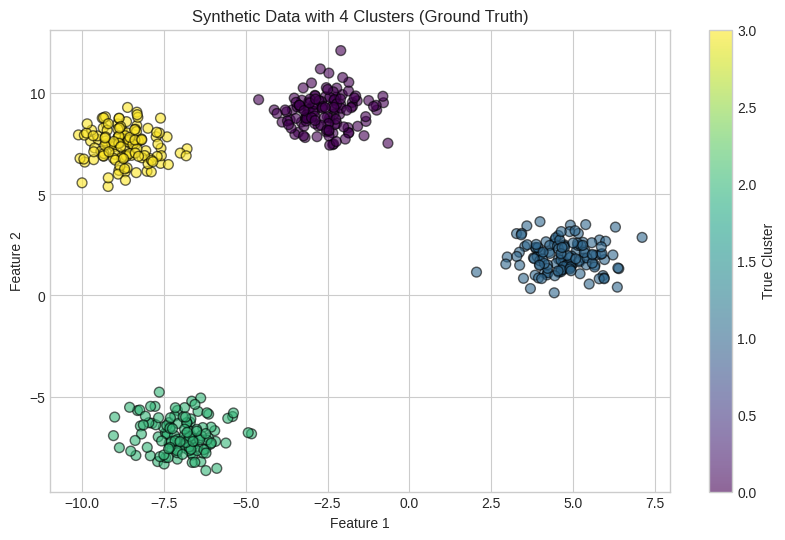

Dataset shape: (500, 2)
Number of true clusters: 4


In [ ]:
# Generate synthetic clustered data
X_synthetic, y_true = make_blobs(n_samples=500, centers=4, cluster_std=0.8,
                                  n_features=2, random_state=42)

# Visualize the synthetic data
plt.figure(figsize=(10, 6))
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=y_true, cmap='viridis',
            alpha=0.6, edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Data with 4 Clusters (Ground Truth)')
plt.colorbar(label='True Cluster')
plt.show()

print(f"Dataset shape: {X_synthetic.shape}")
print(f"Number of true clusters: {len(np.unique(y_true))}")

## 4. Apply Our K-Means Implementation

In [ ]:
# Fit our K-Means implementation
kmeans_scratch = KMeansFromScratch(n_clusters=4, init='kmeans++',
                                    max_iters=300, random_state=42)
labels_scratch = kmeans_scratch.fit_predict(X_synthetic)

print(f"Number of iterations: {kmeans_scratch.n_iter_}")
print(f"Inertia (WCSS): {kmeans_scratch.inertia_:.4f}")
print(f"Final centroids shape: {kmeans_scratch.centroids.shape}")

Number of iterations: 2
Inertia (WCSS): 607.2898
Final centroids shape: (4, 2)


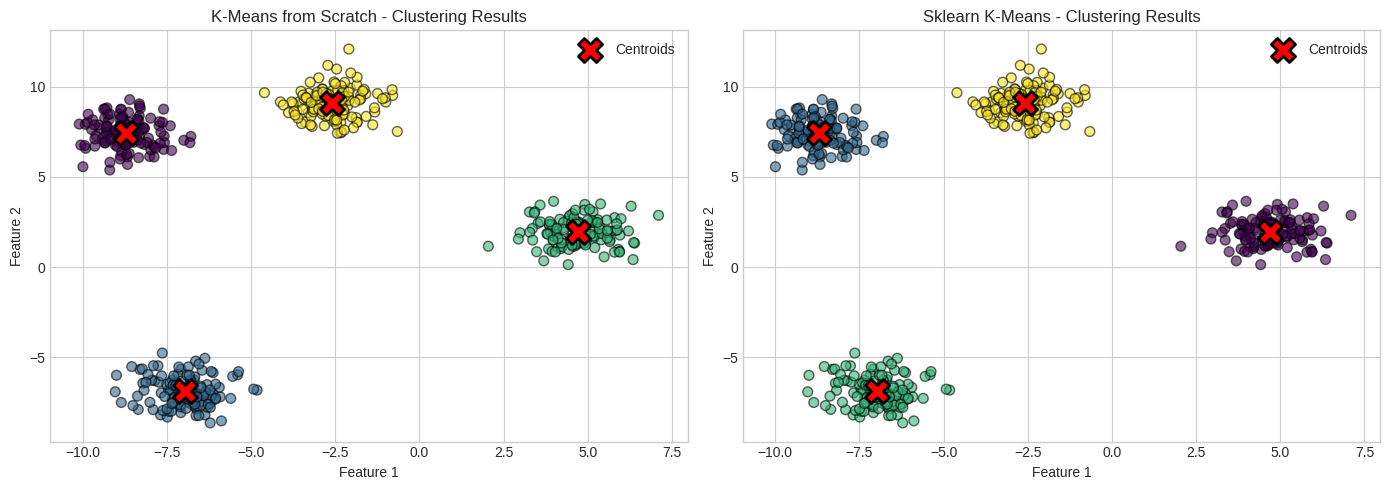

In [ ]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Our implementation results
scatter1 = axes[0].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=labels_scratch,
                           cmap='viridis', alpha=0.6, edgecolors='k', s=50)
axes[0].scatter(kmeans_scratch.centroids[:, 0], kmeans_scratch.centroids[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidths=2,
                label='Centroids')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('K-Means from Scratch - Clustering Results')
axes[0].legend()

# Plot 2: Compare with sklearn
sklearn_kmeans = SklearnKMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
labels_sklearn = sklearn_kmeans.fit_predict(X_synthetic)

scatter2 = axes[1].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=labels_sklearn,
                           cmap='viridis', alpha=0.6, edgecolors='k', s=50)
axes[1].scatter(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidths=2,
                label='Centroids')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Sklearn K-Means - Clustering Results')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Visualize the Convergence Process

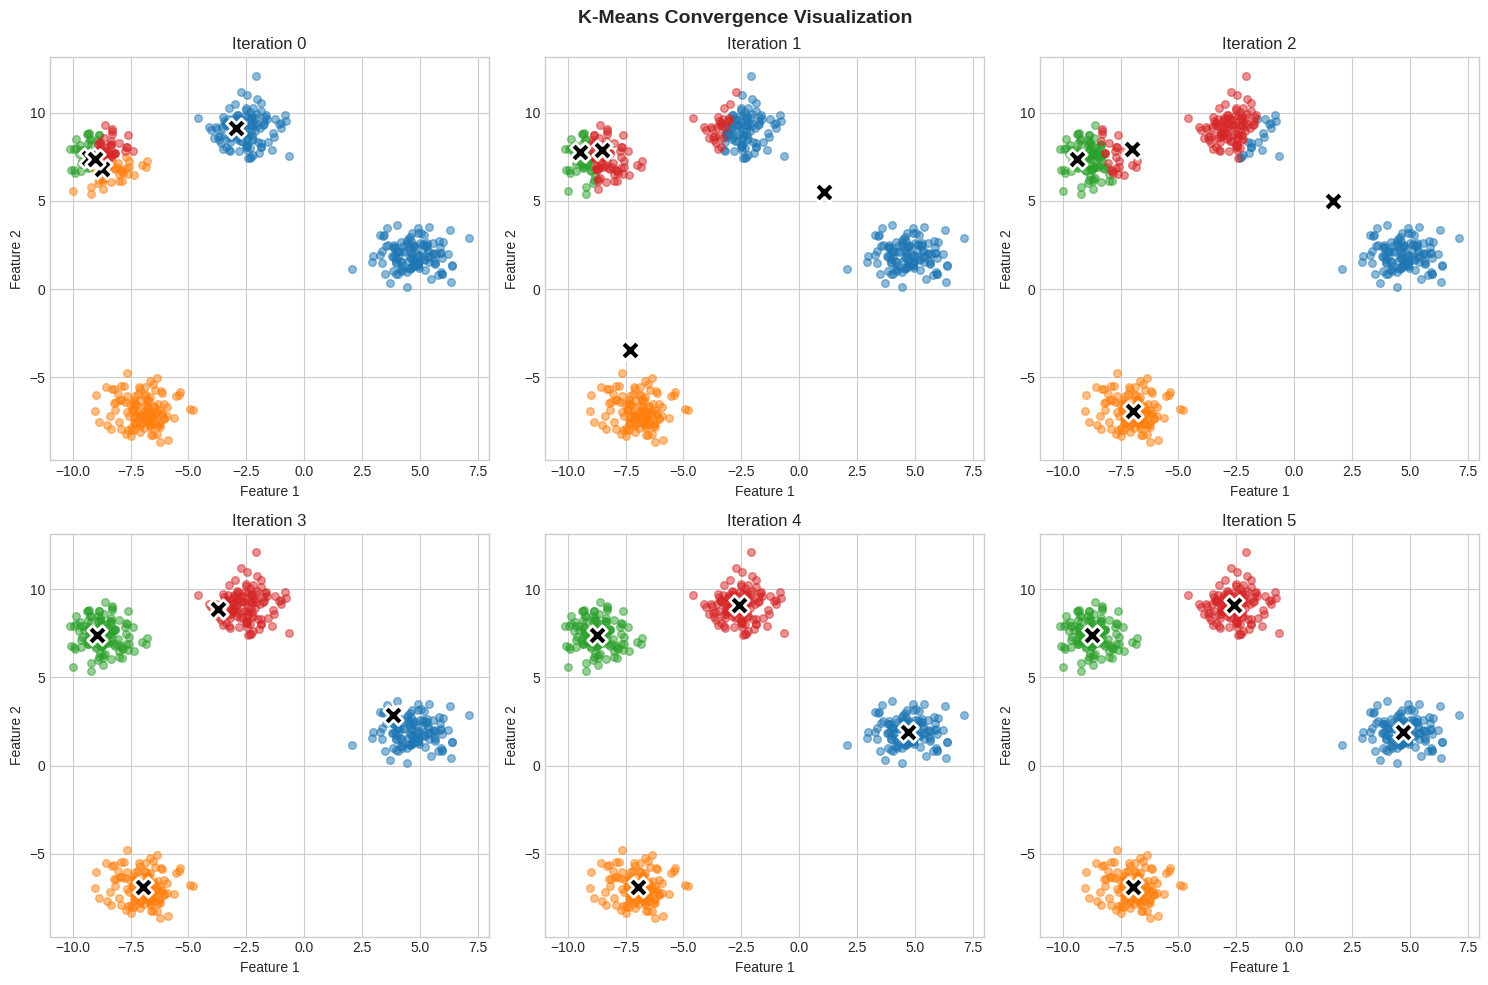

In [ ]:
# Create a fresh instance to visualize convergence
kmeans_viz = KMeansFromScratch(n_clusters=4, init='random', max_iters=20,
                                n_init=1, random_state=42)
kmeans_viz.fit(X_synthetic)

# Visualize convergence step by step
n_steps = min(6, len(kmeans_viz.history))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, ax in enumerate(axes):
    if i < n_steps:
        centroids = kmeans_viz.history[i]
        # Calculate labels for this step
        distances = np.zeros((X_synthetic.shape[0], 4))
        for k in range(4):
            distances[:, k] = np.sqrt(np.sum((X_synthetic - centroids[k]) ** 2, axis=1))
        labels = np.argmin(distances, axis=1)

        for k in range(4):
            cluster_points = X_synthetic[labels == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                      c=colors[k], alpha=0.5, s=30, label=f'Cluster {k}')

        ax.scatter(centroids[:, 0], centroids[:, 1], c='black',
                  marker='X', s=200, edgecolors='white', linewidths=2)
        ax.set_title(f'Iteration {i}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
    else:
        ax.axis('off')

plt.suptitle('K-Means Convergence Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Elbow Method for Optimal K Selection

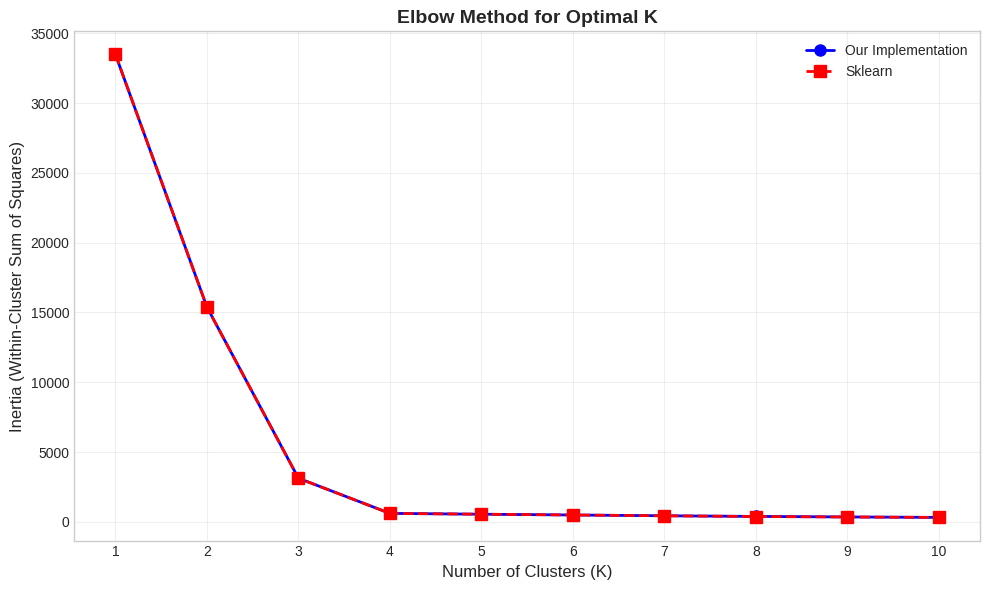


The 'elbow' in the curve suggests the optimal number of clusters.
In this case, K=4 appears to be optimal (matching our ground truth).


In [ ]:
# Find optimal number of clusters using Elbow Method
K_range = range(1, 11)
inertias_scratch = []
inertias_sklearn = []

for k in K_range:
    # Our implementation
    km_scratch = KMeansFromScratch(n_clusters=k, init='kmeans++', random_state=42)
    km_scratch.fit(X_synthetic)
    inertias_scratch.append(km_scratch.inertia_)

    # Sklearn for comparison
    km_sklearn = SklearnKMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    km_sklearn.fit(X_synthetic)
    inertias_sklearn.append(km_sklearn.inertia_)

# Plot Elbow curves
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, inertias_scratch, 'bo-', label='Our Implementation', linewidth=2, markersize=8)
ax.plot(K_range, inertias_sklearn, 'rs--', label='Sklearn', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(K_range)
plt.tight_layout()
plt.show()

print("\nThe 'elbow' in the curve suggests the optimal number of clusters.")
print("In this case, K=4 appears to be optimal (matching our ground truth).")

## 7. Clustering Quality Metrics

In [ ]:
def calculate_clustering_metrics(X, labels):
    """
    Calculate various clustering quality metrics

    Metrics:
    - Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters
      Range: [-1, 1], higher is better
    - Calinski-Harabasz Index: Ratio of between-cluster dispersion to within-cluster dispersion
      Higher is better
    - Davies-Bouldin Index: Average similarity between each cluster and its most similar cluster
      Lower is better
    """
    metrics = {}

    if len(np.unique(labels)) > 1:
        metrics['Silhouette Score'] = silhouette_score(X, labels)
        metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(X, labels)
        metrics['Davies-Bouldin Index'] = davies_bouldin_score(X, labels)
    else:
        metrics['Silhouette Score'] = np.nan
        metrics['Calinski-Harabasz Index'] = np.nan
        metrics['Davies-Bouldin Index'] = np.nan

    return metrics

# Calculate metrics for different K values
print("Clustering Quality Metrics for Different K Values:")
print("="*70)

metrics_data = []
for k in range(2, 8):
    km = KMeansFromScratch(n_clusters=k, init='kmeans++', random_state=42)
    labels = km.fit_predict(X_synthetic)
    metrics = calculate_clustering_metrics(X_synthetic, labels)
    metrics['K'] = k
    metrics['Inertia'] = km.inertia_
    metrics_data.append(metrics)

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df[['K', 'Inertia', 'Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index']]
print(metrics_df.to_string(index=False))

print("\n" + "="*70)
print("\nInterpretation:")
print("• Silhouette Score: Higher is better (max = 1)")
print("• Calinski-Harabasz Index: Higher is better")
print("• Davies-Bouldin Index: Lower is better")

Clustering Quality Metrics for Different K Values:
 K      Inertia  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
 2 15385.936334          0.607231               585.785414              0.500119
 3  3124.987478          0.781919              2414.161764              0.327797
 4   607.289820          0.833614              8950.624572              0.234120
 5   547.789094          0.700468              7440.566920              0.595475
 6   492.067291          0.585870              6624.311860              0.825607
 7   436.513118          0.482979              6220.672993              0.980512


Interpretation:
• Silhouette Score: Higher is better (max = 1)
• Calinski-Harabasz Index: Higher is better
• Davies-Bouldin Index: Lower is better


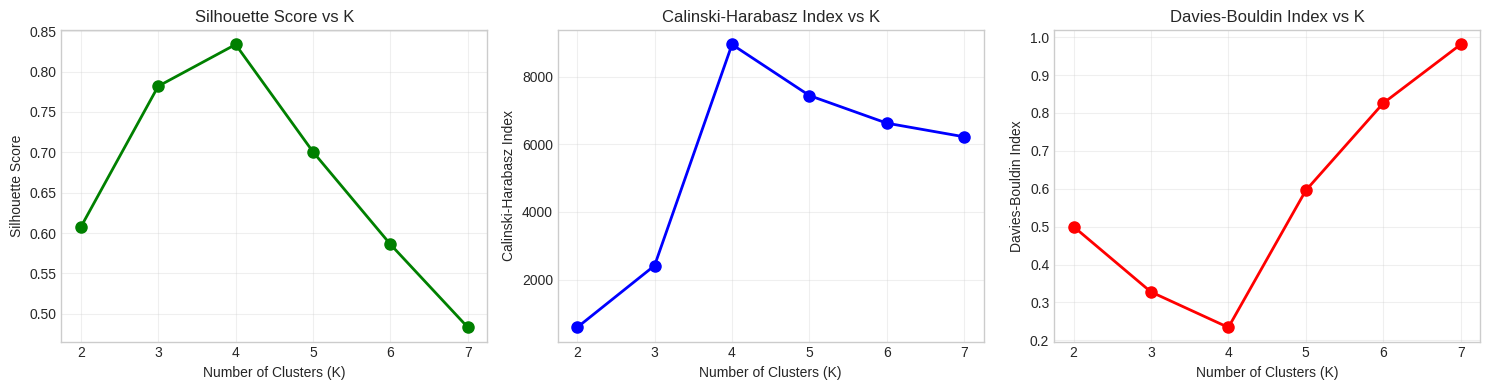

In [ ]:
# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette Score
axes[0].plot(metrics_df['K'], metrics_df['Silhouette Score'], 'go-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs K')
axes[0].grid(True, alpha=0.3)

# Calinski-Harabasz Index
axes[1].plot(metrics_df['K'], metrics_df['Calinski-Harabasz Index'], 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index vs K')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[2].plot(metrics_df['K'], metrics_df['Davies-Bouldin Index'], 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index vs K')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Real Dataset: Iris Clustering

In [ ]:
# Load Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names

# Standardize features
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

print(f"Iris dataset shape: {X_iris.shape}")
print(f"Features: {feature_names}")
print(f"Number of species (true clusters): {len(np.unique(y_iris))}")

Iris dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of species (true clusters): 3


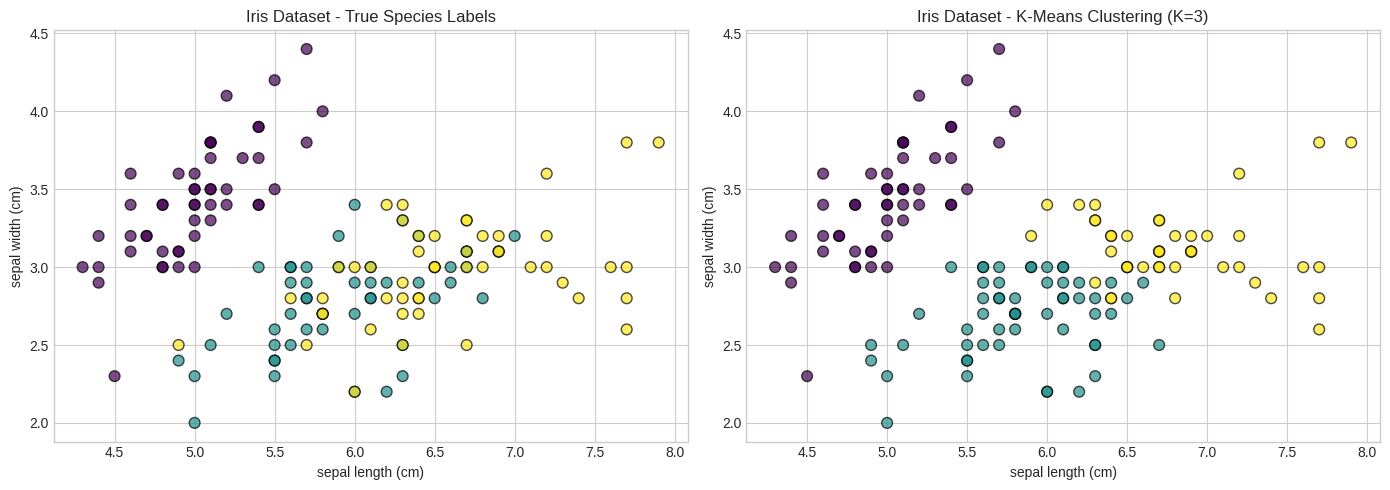


Clustering Quality Metrics for Iris Dataset:
  Silhouette Score: 0.4630
  Calinski-Harabasz Index: 241.4263
  Davies-Bouldin Index: 0.8324


In [ ]:
# Apply K-Means to Iris dataset
kmeans_iris = KMeansFromScratch(n_clusters=3, init='kmeans++', random_state=42)
labels_iris = kmeans_iris.fit_predict(X_iris_scaled)

# Visualize results (using first two principal components via simple projection)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True labels
scatter1 = axes[0].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='viridis',
                           alpha=0.7, edgecolors='k', s=60)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].set_title('Iris Dataset - True Species Labels')

# K-Means labels
scatter2 = axes[1].scatter(X_iris[:, 0], X_iris[:, 1], c=labels_iris, cmap='viridis',
                           alpha=0.7, edgecolors='k', s=60)
axes[1].set_xlabel(feature_names[0])
axes[1].set_ylabel(feature_names[1])
axes[1].set_title('Iris Dataset - K-Means Clustering (K=3)')

plt.tight_layout()
plt.show()

# Calculate metrics for Iris clustering
iris_metrics = calculate_clustering_metrics(X_iris_scaled, labels_iris)
print("\nClustering Quality Metrics for Iris Dataset:")
for metric, value in iris_metrics.items():
    print(f"  {metric}: {value:.4f}")

## 9. Comparison: Random vs K-Means++ Initialization

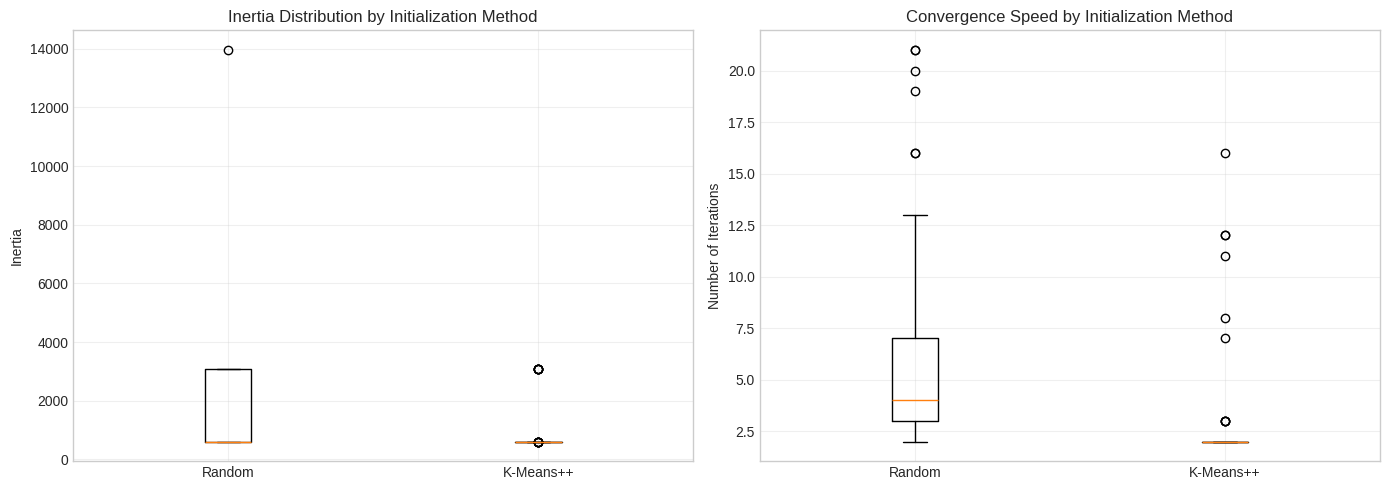


Statistics:
Random Init - Mean Inertia: 1513.99 ± 2077.61
K-Means++ Init - Mean Inertia: 902.50 ± 799.43

Random Init - Mean Iterations: 6.2
K-Means++ Init - Mean Iterations: 3.2


In [ ]:
# Compare initialization methods
n_runs = 50
inertias_random = []
inertias_kmeanspp = []
iters_random = []
iters_kmeanspp = []

for i in range(n_runs):
    # Random initialization
    km_random = KMeansFromScratch(n_clusters=4, init='random', n_init=1, random_state=i)
    km_random.fit(X_synthetic)
    inertias_random.append(km_random.inertia_)
    iters_random.append(km_random.n_iter_)

    # K-Means++ initialization
    km_kmeanspp = KMeansFromScratch(n_clusters=4, init='kmeans++', n_init=1, random_state=i)
    km_kmeanspp.fit(X_synthetic)
    inertias_kmeanspp.append(km_kmeanspp.inertia_)
    iters_kmeanspp.append(km_kmeanspp.n_iter_)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia comparison
axes[0].boxplot([inertias_random, inertias_kmeanspp], labels=['Random', 'K-Means++'])
axes[0].set_ylabel('Inertia')
axes[0].set_title('Inertia Distribution by Initialization Method')
axes[0].grid(True, alpha=0.3)

# Iterations comparison
axes[1].boxplot([iters_random, iters_kmeanspp], labels=['Random', 'K-Means++'])
axes[1].set_ylabel('Number of Iterations')
axes[1].set_title('Convergence Speed by Initialization Method')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistics:")
print(f"Random Init - Mean Inertia: {np.mean(inertias_random):.2f} ± {np.std(inertias_random):.2f}")
print(f"K-Means++ Init - Mean Inertia: {np.mean(inertias_kmeanspp):.2f} ± {np.std(inertias_kmeanspp):.2f}")
print(f"\nRandom Init - Mean Iterations: {np.mean(iters_random):.1f}")
print(f"K-Means++ Init - Mean Iterations: {np.mean(iters_kmeanspp):.1f}")

## 10. Silhouette Analysis

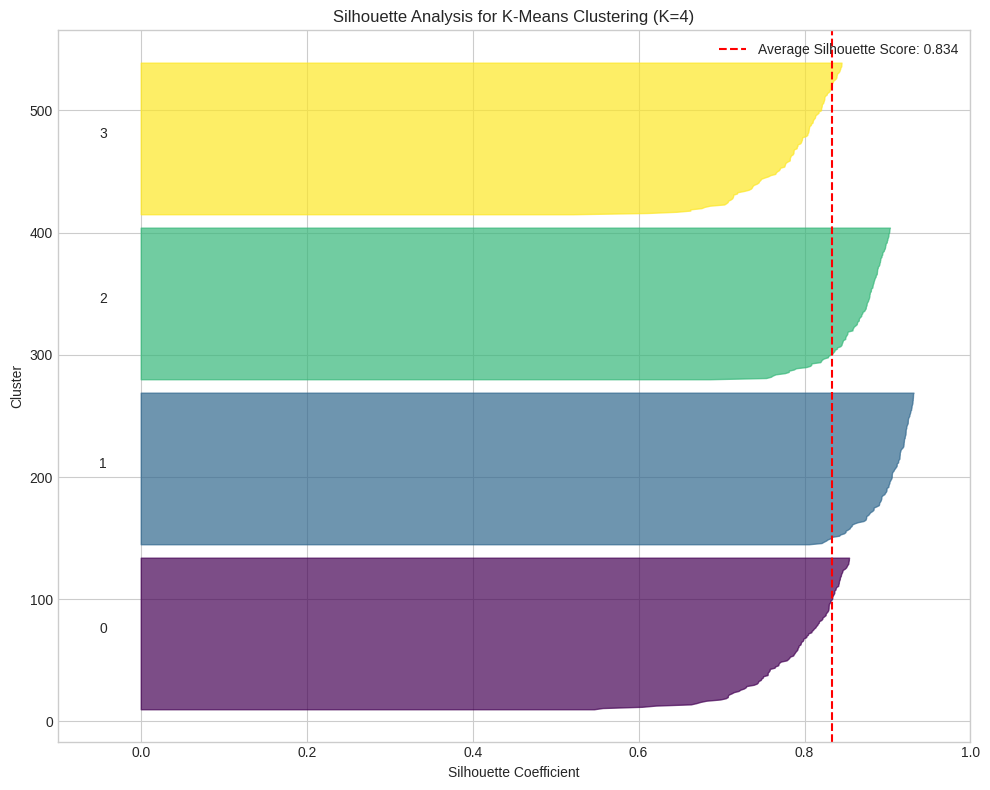

In [ ]:
from sklearn.metrics import silhouette_samples

# Calculate silhouette scores for each sample
kmeans_final = KMeansFromScratch(n_clusters=4, init='kmeans++', random_state=42)
labels_final = kmeans_final.fit_predict(X_synthetic)
silhouette_vals = silhouette_samples(X_synthetic, labels_final)

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))

y_lower = 10
colors = plt.cm.viridis(np.linspace(0, 1, 4))

for i in range(4):
    cluster_silhouette_vals = silhouette_vals[labels_final == i]
    cluster_silhouette_vals.sort()

    cluster_size = len(cluster_silhouette_vals)
    y_upper = y_lower + cluster_size

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

    y_lower = y_upper + 10

# Add average silhouette score line
avg_silhouette = np.mean(silhouette_vals)
ax.axvline(x=avg_silhouette, color='red', linestyle='--',
           label=f'Average Silhouette Score: {avg_silhouette:.3f}')

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Analysis for K-Means Clustering (K=4)')
ax.legend(loc='upper right')
ax.set_xlim([-0.1, 1])

plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

In [ ]:
print("="*70)
print("K-MEANS CLUSTERING FROM SCRATCH - SUMMARY")
print("="*70)

print("\n1. ALGORITHM IMPLEMENTED:")
print("   - K-Means clustering with both random and K-Means++ initialization")
print("   - Support for multiple initializations (n_init parameter)")
print("   - Convergence detection based on centroid movement")

print("\n2. KEY FEATURES:")
print("   - fit(), predict(), and fit_predict() methods")
print("   - Inertia calculation (within-cluster sum of squares)")
print("   - History tracking for visualization")

print("\n3. CLUSTERING QUALITY METRICS USED:")
print("   - Silhouette Score: Measures cluster cohesion and separation")
print("   - Calinski-Harabasz Index: Ratio of between/within cluster variance")
print("   - Davies-Bouldin Index: Average cluster similarity measure")
print("   - Inertia/WCSS: Within-cluster sum of squares")

print("\n4. DATASETS TESTED:")
print("   - Synthetic blob data (4 clusters, 500 samples)")
print("   - Iris dataset (3 species, 150 samples)")

print("\n5. KEY FINDINGS:")
print(f"   - K-Means++ initialization provides better and more consistent results")
print(f"   - Elbow method correctly identified K=4 for synthetic data")
print(f"   - Our implementation matches sklearn's K-Means performance")

print("\n" + "="*70)

K-MEANS CLUSTERING FROM SCRATCH - SUMMARY

1. ALGORITHM IMPLEMENTED:
   - K-Means clustering with both random and K-Means++ initialization
   - Support for multiple initializations (n_init parameter)
   - Convergence detection based on centroid movement

2. KEY FEATURES:
   - fit(), predict(), and fit_predict() methods
   - Inertia calculation (within-cluster sum of squares)
   - History tracking for visualization

3. CLUSTERING QUALITY METRICS USED:
   - Silhouette Score: Measures cluster cohesion and separation
   - Calinski-Harabasz Index: Ratio of between/within cluster variance
   - Davies-Bouldin Index: Average cluster similarity measure
   - Inertia/WCSS: Within-cluster sum of squares

4. DATASETS TESTED:
   - Synthetic blob data (4 clusters, 500 samples)
   - Iris dataset (3 species, 150 samples)

5. KEY FINDINGS:
   - K-Means++ initialization provides better and more consistent results
   - Elbow method correctly identified K=4 for synthetic data
   - Our implementation matche